In [41]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
%matplotlib inline 
import numpy as np
import pandas as pd
from scipy.stats import invgamma
import sqlite3
import time

In [2]:
def readData(filename, tablename):
    conn = sqlite3.connect(filename)
    c = conn.cursor()
    Dict = []
    sql_command = 'SELECT * FROM ' + tablename
    for row in c.execute(sql_command):
        Dict.append(row)
    data = pd.DataFrame(Dict)
    data.columns = ['index','buy/sell','price','size','ob_level','timestamp']
    data['timestamp'] = pd.to_datetime(data.timestamp)
    bid = data[(data['buy/sell'] == 'buy') & (data['ob_level'] == 1)
               & ((data['index']-1)%200==0)]
    ask = data[(data['buy/sell'] == 'sell') & (data['ob_level'] == 1)
               & ((data['index']-11)%200==0)]
    return bid,ask

bid, ask = readData('okcoin.rdb','okcoin_ob')

In [4]:
def create_lags(data):
    concat_list = [data,data['price'].shift(1)]
    data = pd.concat(concat_list,axis=1).dropna()
    col_names = ["old_index","buy/sell","price","size","ob_level","timestamp","lag1"]
    data.columns = col_names
    newColList = ["diff1"]
    lagList = ["lag1"]
    for i in xrange(len(newColList)):
        data[newColList[i]] = (np.log(data["price"]) - np.log(data[lagList[i]]))
    return data

bid = create_lags(bid)

In [10]:
def graphRawFX():
    fig = plt.figure(figsize=(10,7))
    ax1 = plt.subplot2grid((40,40),(0,0),rowspan=40,colspan=40)

    ax1.plot(range(len(bid)),bid['price'], label="bid")
    #ax1.plot(range(len(ask)),ask['price'], label="ask")
    ax1.legend()
    plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
    ax1_2 = ax1.twinx()

    #ax1_2.fill_between(range(bid.shape[0]),0,(np.array(ask['price'])-np.array(bid['price'])),facecolor='g', alpha=.3)
    
    plt.subplots_adjust(bottom=.23)
    plt.grid(True)
    plt.show()
graphRawFX()

In [51]:
def gibbs(data, N=10000, start = [0,0.00001]):
    data = np.array(data)
    m=start[0]
    v=start[1]
    samples=np.zeros((2,N+1))
    samples[0,0]=m
    samples[1,0]=v
    E0 = 1.
    V0 = 1.
    alpha0 = 1.
    beta0 = 1.
    n = len(data)
    alpha = alpha0 + n/2.
    beta = beta0 + 0.5*sum((data-m)**2)
    
    V = (1./V0 + n/v)**(-1)
    E = V * (E0/V0 * sum(data)/v)
    
    for i in range(1,N,2):
        m=np.random.normal(E, V)
        samples[0,i]=m
        samples[1,i]=v
        V = (1./V0 + n/v)**(-1)
        E = V * (E0/V0 * sum(data)/v)
        
        v=invgamma.rvs(alpha, scale = beta)
        samples[0,i+1]=m
        samples[1,i+1]=v
        
        alpha = alpha0 + n/2.
        beta = beta0 + 0.5*sum((data-m)**2)
        
    return samples[:,:N]

In [61]:
inputData = bid['diff1'].tolist()
result = gibbs(inputData, N=10000, start = [0,1])

In [81]:
def Gibbs_plot(result, thin=1):
    x_sample, y_sample = result[0,:], result[1,:]
    x_sample = x_sample[0:len(x_sample):thin]
    y_sample = y_sample[0:len(y_sample):thin]
    fig, ax = plt.subplots(figsize = (15, 5))
    ax = fig.add_subplot(131)
    ax.scatter(x_sample, y_sample,alpha = 0.2)
    plt.xlabel('m')
    plt.ylabel('v')
    plt.xlim([0.000007,0.0000071])
    plt.ylim([0.00012,0.00014])
    ax = fig.add_subplot(132)
    ax.plot(x_sample)
    plt.xlabel('number')
    plt.ylabel('m')
    plt.ylim([0.000007,0.0000071])
    ax = fig.add_subplot(133)
    ax.plot(y_sample)
    plt.xlabel('number')
    plt.ylabel('v')
    plt.ylim([0.00012,0.00014])
    plt.show()

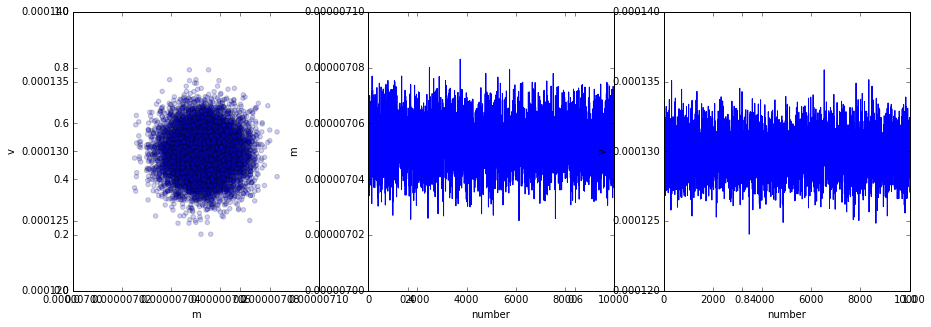

In [82]:
Gibbs_plot(result)

In [83]:
def acorrPlot(sample1, sample2):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.acorr(sample1-np.mean(sample1), maxlags=40)
    plt.xlim([0,40])
    plt.xlabel("x")
    plt.subplot(1,2,2)
    plt.acorr(sample2-np.mean(sample2), maxlags=40)
    plt.xlim([0,40])
    plt.xlabel("y")
    plt.show()

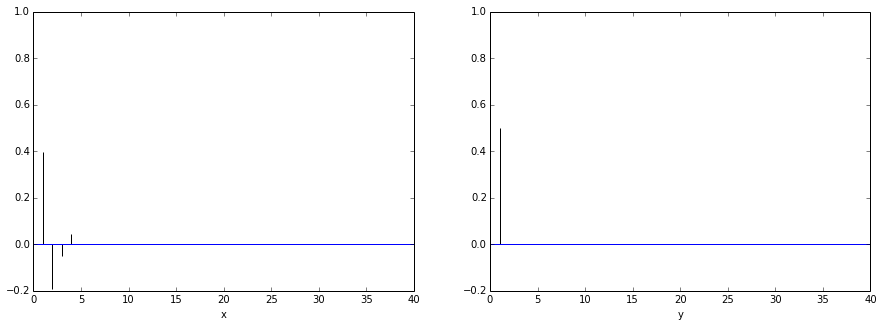

In [84]:
acorrPlot(result[0,:], result[1,:])